# The flow of the OCR system

#### Get the input image

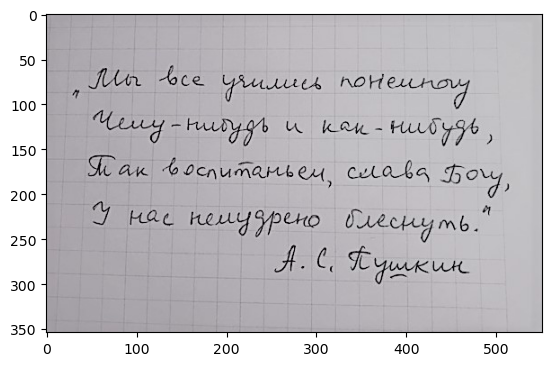

In [1]:
import cv2 
import os 
from matplotlib import pyplot as plt

image = cv2.imread(os.path.join(os.getcwd(), 'test.jpeg'))

plt.imshow(image)

#### Split the image of handwritten text into rows

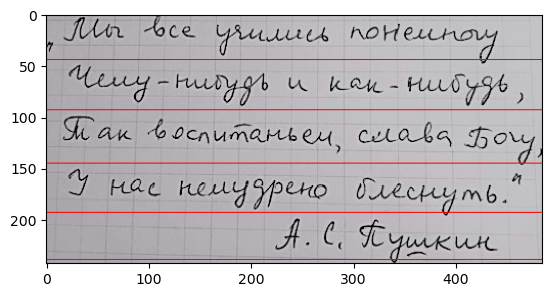

In [8]:
from chunking import Process, Trim

image = Trim(Trim(image, vertical=False), vertical=True)

segmented_image, hor_lines = Process(image, vertical=False) # horizontal lines 
# segmented_image - image with text split into rows for visualisation 
# lines - pixels of where rows are split

plt.imshow(segmented_image)

#### Each row of text is passed to the process function with "vertical=True", splitting the rows into words

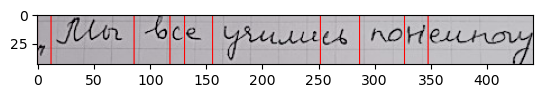

In [9]:

row_sample = image[hor_lines[0]:hor_lines[1]]

row_sample = Trim(Trim(row_sample, vertical=False), vertical=True, rowFiltering=True)

segmented_row, ver_lines = Process(row_sample, vertical=True)

plt.imshow(segmented_row)

#### ver_lines then is filtered, and the row is split into suitable chunks to pass to the model

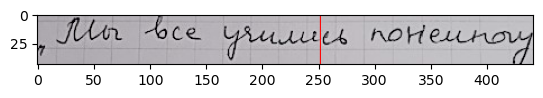

In [10]:
from chunking import VerFilter, DrawLines
import numpy as np

chunks = VerFilter(row_sample, ver_lines) # the function breaks down the row into chunks

splittings = [chunk.shape[1] for chunk in chunks]
splittings = [sum(splittings[:i+1]) for i in range(len(splittings))]

plt.imshow(DrawLines(np.concatenate(chunks, axis=1), splittings, vertical=True))

#### Each chunk is passed to the model to predict the text

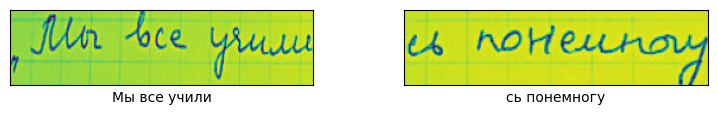

In [11]:
import torch 
from PIL import Image
from torchvision.transforms import transforms
from predict import Predict 
from ModelBuilding.RnnModel import Model
from ModelBuilding.TrainEvaluate import TransformList

ALPHABET=' %(),-./0123456789:;?[]«»АБВГДЕЖЗИЙКЛМНОПРСТУФХЦЧШЩЭЮЯабвгдежзийклмнопрстуфхцчшщъыьэюяё-'
DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

model = Model(256, len(ALPHABET) + 1)
model.to(DEVICE)
model.load_state_dict(torch.load(os.path.join(os.getcwd(), 'CNNLstm.pt'), weights_only=False, map_location=DEVICE))

transformator =transforms.Compose(TransformList().transform_list)
tensor_chunks = []

for chunk in chunks:

    chunk = Image.fromarray(chunk)
    chunk = transformator(chunk)

    tensor_chunks.append(chunk)

tensor_chunks = torch.stack(tensor_chunks)

predictions = Predict(model, tensor_chunks)    

num_images = tensor_chunks.size(0)
columns = len(chunks) 
rows = 1 

fig = plt.figure(figsize=(9, 1))

for i in range(num_images):

    ax = fig.add_subplot(rows, columns, i + 1)
    ax.imshow(tensor_chunks[i].permute(1, 2, 0)) 
    ax.set_xlabel(predictions[i], fontsize=10)  
    ax.yaxis.set_visible(False) 
    ax.tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False) 

plt.subplots_adjust(wspace=0.3, hspace=0.1)
plt.show()

#### All of the flow is enclosed in TranscribeImage function from predict

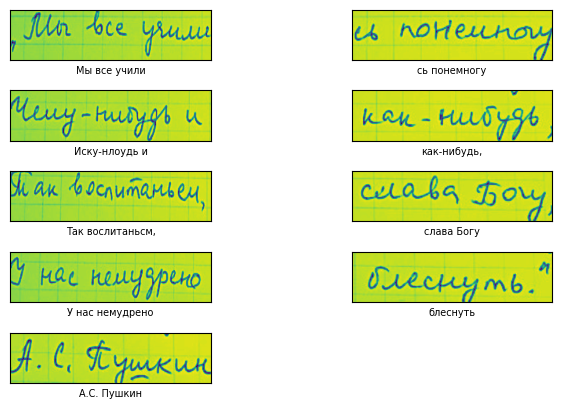

In [6]:
from predict import TranscribeImage


output, _ = TranscribeImage(image, visualise=True)

Given the output, one may use llm to proofread and fix the errors

Мы все учили сь понемногу
Иску-нлоудь и как-нибудь,
Так вослитаньсм, слава Богу
У нас немудрено блеснуть
А.С. Пушкин



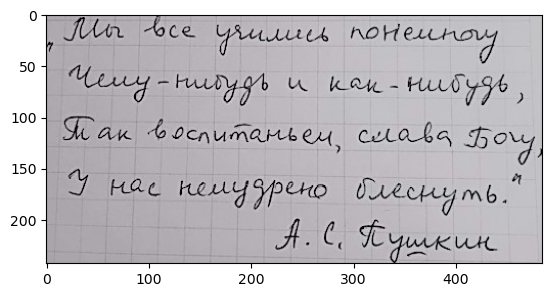

In [7]:
plt.imshow(image)
print(output)